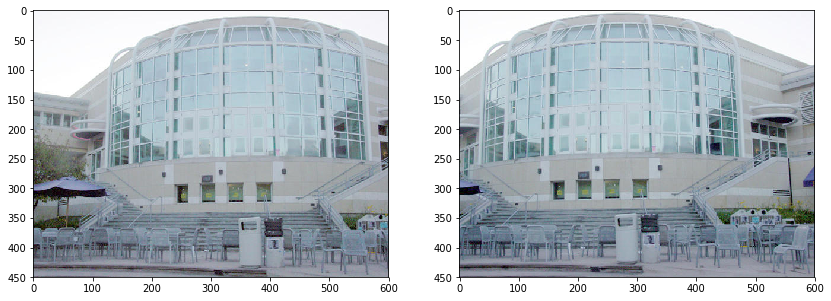

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()



In [2]:
def corner(I, w, t, w_nms):
# inputs:
# I is the input image (may be mxn for BW or mxnx3 for RGB)
# w is the size of the window used to compute the gradient matrix N
# t is the minor eigenvalue threshold
# w_nms is the size of the window used for nonmaximal supression
# outputs:
# J0 is the mxn image of minor eigenvalues of N before thresholding
# J1 is the mxn image of minor eigenvalues of N after thresholding
# J2 is the mxn image of minor eigenvalues of N after nonmaximal supression
# pts0 is the 2xk list of coordinates of (pixel accurate) corners
# (ie. coordinates of nonzero values of J2)
# pts1 is the 2xk list of coordinates of subpixel accurate corners
# found using the Forstner detector

    """your code here"""
    if I.shape[2]==3:
        r, g, b = I[:,:,0], I[:,:,1], I[:,:,2]
        I = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    
    
    m,n = I.shape[:2]
   
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))
    J2 = np.zeros((m,n))

    w_2=(w-1)//2
    w_num_2=(w_nms-1)//2

    thres=t
    kx=np.array([-1,8,0,-8,1])/12

    Ix0 = np.zeros((m,n))
    Iy0 = np.zeros((n,m))

    for i in range(len(I)):
        Ix0[i]=np.convolve(kx,I[i],'same')

    for i in range(len(I.transpose())):
        Iy0[i]=np.convolve(kx,I.transpose()[i],'same')
    Iy0=Iy0.transpose()
    
    IxIx=np.multiply(Ix0,Ix0)
    IxIy=np.multiply(Ix0,Iy0)
    IyIx=np.multiply(Iy0,Ix0)
    IyIy=np.multiply(Iy0,Iy0)
    N=np.zeros((2,2))

    pts0 = np.array([0,0])
    pts1 = np.array([0,0])
    N2=np.zeros((2,1))

    for i in range(w_2,m-w_2):
        for j in range(w_2,n-w_2):
            N[0][0]=np.sum(IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
            N[0][1]=np.sum(IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
            N[1][0]=np.sum(IyIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
            N[1][1]=np.sum(IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)

            #sq_temp=np.trace(N)**2-4*np.linalg.det(N)

            lbd_l=(np.trace(N)-abs(np.trace(N)**2-4*np.linalg.det(N))**0.5)/2
            #lbd_l=(np.trace(N)-((sq_temp>0)*sq_temp)**0.5)/2

            J0[i][j]=lbd_l

    J1=np.multiply(J0>thres,J0)    

    for i in range(w_num_2,m-w_num_2):
        for j in range(w_num_2,n-w_num_2):
            J2[i][j]=(J1[i][j] == np.max(J1[i-w_num_2:i+w_num_2+1,j-w_num_2:j+w_num_2+1]))*J1[i][j]

    for i in range(m):
        for j in range(n):
            if J2[i][j]>0:
                pts0=np.row_stack((pts0, np.array([i,j])))

    pts0=np.delete(pts0,0,0)

    for [i,j] in pts0:

        x_temp=np.dot(np.ones((w,1)),np.array([range(i-w_2,i+w_2+1)]))
        y_temp=np.dot(np.ones((w,1)),np.array([range(j-w_2,j+w_2+1)]))
        x_temp=x_temp.transpose()

        N[0][0]=np.sum(IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])
        N[0][1]=np.sum(IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])
        N[1][0]=np.sum(IyIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])
        N[1][1]=np.sum(IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])

        N2[0]=np.sum(np.multiply(x_temp,IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])+\
                     np.multiply(y_temp,IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1]))

        N2[1]=np.sum(np.multiply(x_temp,IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])+\
                     np.multiply(y_temp,IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1]))

        pts1=np.row_stack((pts1, np.linalg.solve(N,N2).transpose()))

    pts1=np.delete(pts1,0,0)
    pts0=pts0.transpose()
    pts1=pts1.transpose()
    
    return J0, J1, J2, pts0, pts1


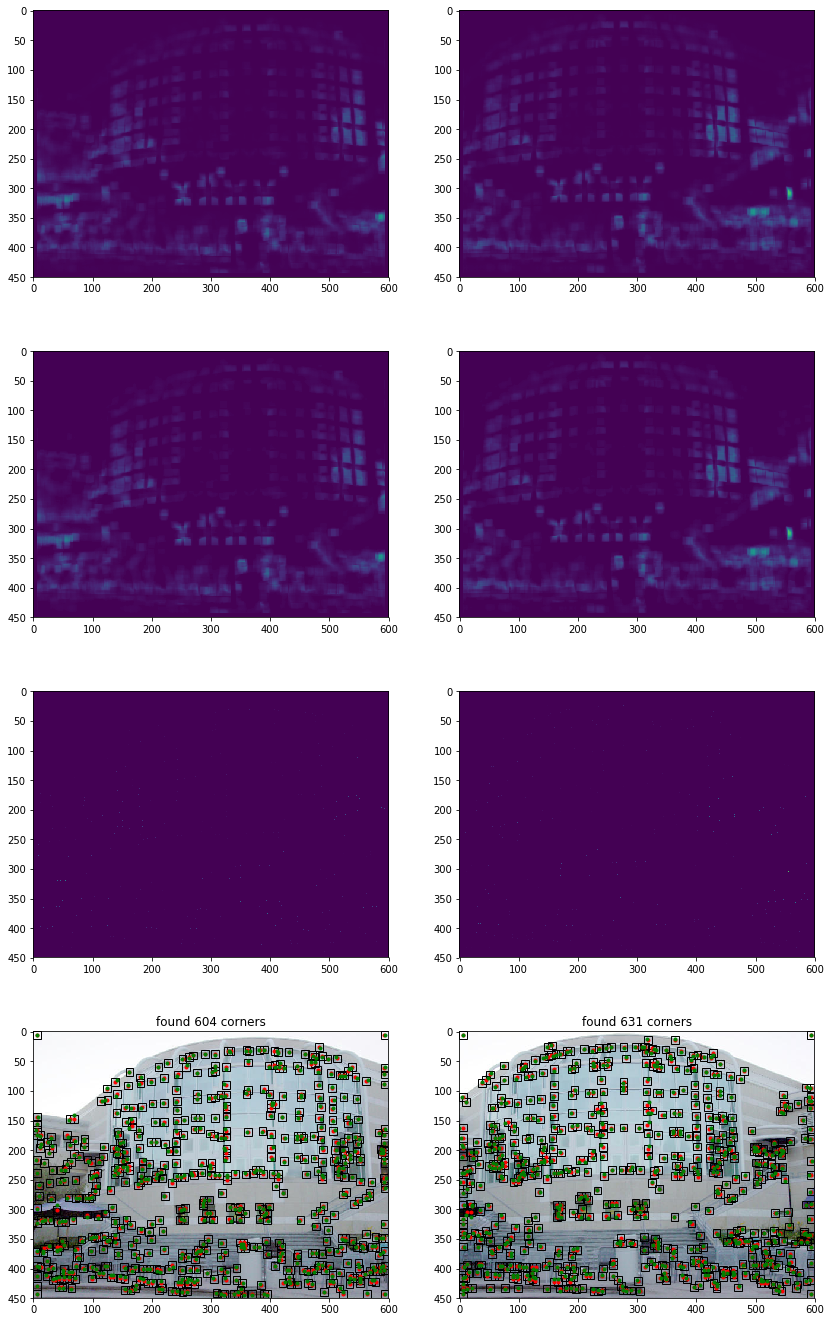

In [3]:
# parameters to tune
w=13
t=0.00025
w_nms=7
# extract corners
J1_0, J1_1, J1_2, pts1_0, pts1_1 = corner(I1, w, t, w_nms)
J2_0, J2_1, J2_2, pts2_0, pts2_1 = corner(I2, w, t, w_nms)
# Display results
plt.figure(figsize=(14,24))
# show pre-thresholded corner heat map
plt.subplot(4,2,1)
plt.imshow(J1_0)
plt.subplot(4,2,2)
plt.imshow(J2_0)
# show thresholded corner heat map
plt.subplot(4,2,3)
plt.imshow(J1_1)
plt.subplot(4,2,4)
plt.imshow(J2_1)
# show corner heat map after nonmaximal supression
plt.subplot(4,2,5)
plt.imshow(J1_2)
plt.subplot(4,2,6)
plt.imshow(J2_2)
# show corners on origional images
ax = plt.subplot(4,2,7)
plt.imshow(I1)
# draw rectangles of size w around corners
for i in range(pts1_0.shape[1]):
    y,x = pts1_0[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.plot(pts1_0[1,:], pts1_0[0,:], '.r') # display pixel accurate corners
plt.plot(pts1_1[1,:], pts1_1[0,:], '.g') # display subpixel corners
plt.title('found %d corners'%pts1_0.shape[1])
ax = plt.subplot(4,2,8)
plt.imshow(I2)
for i in range(pts2_0.shape[1]):
    y,x = pts2_0[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
plt.plot(pts2_0[1,:], pts2_0[0,:], '.r')
plt.plot(pts2_1[1,:], pts2_1[0,:], '.g')
plt.title('found %d corners'%pts2_0.shape[1])
plt.show()

In [4]:

def match(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the proximity threshold
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1
    # and inds[1,i] indexs a point in pts2, where k is the number of matches
    # scores is a vector of length k that contains the correlation
    # coefficients of the matches
    """your code here"""
    
    pts1=pts1.transpose()
    pts2=pts2.transpose()

    w_2=(w-1)//2
    m_corr,n_corr = 0,0
    corr_mat = np.zeros((pts1.shape[0],pts2.shape[0]))-1
    
    
    '''
        I1_bw=
        r, g, b = I[:,:,0], I[:,:,1], I[:,:,2]
        I = 0.2989 * r + 0.5870 * g + 0.1140 * b
    '''
    
    
    
    
    for [i1,j1] in pts1:
        if (i1-w_2<0) or (i1+w_2+1>I1.shape[0]) or (j1-w_2 < 0) or (j1 + w_2+1>I1.shape[1]):
            m_corr=m_corr+1
            n_corr=0
            continue
            
        i1=int(round(i1))
        j1=int(round(j1))
        
        
        
        win_temp0=I1[i1-w_2:i1+w_2+1,j1-w_2:j1+w_2+1][0]
        win_temp1=I1[i1-w_2:i1+w_2+1,j1-w_2:j1+w_2+1][1]
        win_temp2=I1[i1-w_2:i1+w_2+1,j1-w_2:j1+w_2+1][2]
        
        win_mean1_0= win_temp0 - np.mean(win_temp0)
        win_mean1_1= win_temp1 - np.mean(win_temp1)
        win_mean1_2= win_temp2 - np.mean(win_temp2)
        
        win_sigma1_0=(np.sum(win_mean1_0**2))**0.5
        win_sigma1_1=(np.sum(win_mean1_1**2))**0.5
        win_sigma1_2=(np.sum(win_mean1_2**2))**0.5
        
        
        
        for [i2,j2] in pts2:
            
            
            if i2-w_2<0 or i2+w_2+1>I2.shape[0] or j2-w_2 < 0 or j2 + w_2+1>I2.shape[1]:
                n_corr=n_corr+1
                continue
                
            i2=int(round(i2))
            j2=int(round(j2))
                
            if np.linalg.norm(np.array(([i1-i2,j1-j2]))) < p:    

                win_temp0=I2[i2-w_2:i2+w_2+1,j2-w_2:j2+w_2+1][0]
                win_temp1=I2[i2-w_2:i2+w_2+1,j2-w_2:j2+w_2+1][1]
                win_temp2=I2[i2-w_2:i2+w_2+1,j2-w_2:j2+w_2+1][2]
                
                win_mean2_0= win_temp0 - np.mean(win_temp0)
                win_mean2_1= win_temp1 - np.mean(win_temp1)
                win_mean2_2= win_temp2 - np.mean(win_temp2)
                
                win_sigma2_0=(np.sum(win_mean2_0**2))**0.5
                win_sigma2_1=(np.sum(win_mean2_1**2))**0.5
                win_sigma2_2=(np.sum(win_mean2_2**2))**0.5
                
                corr_val0=np.sum(np.multiply(win_mean1_0,win_mean2_0))/(win_sigma1_0*win_sigma2_0)
                corr_val1=np.sum(np.multiply(win_mean1_1,win_mean2_1))/(win_sigma1_1*win_sigma2_1)
                corr_val2=np.sum(np.multiply(win_mean1_2,win_mean2_2))/(win_sigma1_2*win_sigma2_2)
                
                #corr_mat[m_corr][n_corr]=np.sum(np.multiply(win_mean1,win_mean2))/\
                #(win_sigma1*win_sigma2)
                
                corr_mat[m_corr][n_corr]=min(corr_val0,corr_val1,corr_val2)

            n_corr=n_corr+1
        m_corr=m_corr+1
        n_corr=0
    print('coeff done')
    
    corr_mask = np.ones((list(corr_mat.shape)), dtype = np.bool)
    inds=np.zeros((1,2),dtype=int)
   
    for i in range(corr_mask.shape[0]):
        for j in range(corr_mask.shape[1]):

            if corr_mask[i][j] and corr_mat[i][j]>t:
                max_temp=corr_mat[i][j]
                corr_mat[i][j]=-1
                max_next=max(max(corr_mat[i,:]),max(corr_mat[:,j]))
                corr_mat[i][j]=max_temp
                if (1-max_temp)<(1-max_next)*d:
                    inds= np.row_stack((inds,np.array(([i,j]))))
                    corr_mask[i,:]=False
                    corr_mask[:,j]=False

    inds=(inds.transpose())
    inds=np.delete(inds,0,1)  
    

    print('loop end')
    
    scores = np.random.rand(200)
    return inds, scores
    

coeff done
loop end


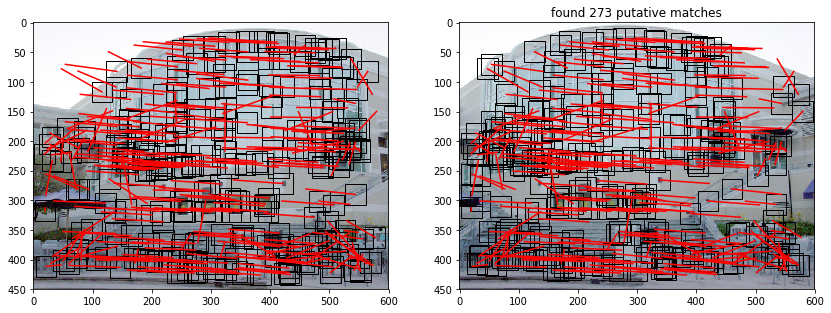

In [6]:
#parameters to tune
w1 = 35
t1 = 0.3
d1 = 1.1
p1 = 88
# do the matching
inds, scores = match(I1, I2, pts1_1, pts2_1, w1, t1, d1, p1)
# display the results
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)

#plt.imshow(np.hstack((I1,I2)))
plt.imshow(I1)
ax2 = plt.subplot(1,2,2)
plt.imshow(I2)
for i in range(inds.shape[1]):
    ii = inds[0,i]
    jj = inds[1,i]
    x1 = pts1_1[0,ii]
    x2 = pts2_1[0,jj]# + I1.shape[1]
    y1 = pts1_1[1,ii]
    y2 = pts2_1[1,jj]
    
    x1,y1=y1,x1
    x2,y2=y2,x2
    
    ax1.plot([x1, x2],[y1, y2],'-r')
    
    ax2.plot([x1, x2],[y1, y2],'-r')
    
    ax1.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False))
    ax2.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False))

plt.title('found %d putative matches' %inds.shape[1])

plt.show()

In [91]:
### correlation coefficient with all windows in images


pts1=pts1_1.transpose()
pts2=pts2_1.transpose()
w=31
t=0
d=12
p=np.inf

w_2=(w-1)//2
m_corr,n_corr = 0,0
corr_mat = np.zeros((pts1.shape[0],pts2.shape[0]))-1


for [i1,j1] in pts1:
    if (i1-w_2<0) or (i1+w_2+1>I1.shape[0]) or (j1-w_2 < 0) or (j1 + w_2+1>I1.shape[1]):
        m_corr=m_corr+1
        n_corr=0
        continue
    i1=int(round(i1))
    j1=int(round(j1))
    
    win_temp=I1[i1-w_2:i1+w_2+1,j1-w_2:j1+w_2+1]
    win_mean1= win_temp - np.mean(win_temp)
    win_sigma1=(np.sum(win_mean1**2))**0.5
    for [i2,j2] in pts2:
        if i2-w_2<0 or i2+w_2+1>I2.shape[0] or j2-w_2 < 0 or j2 + w_2+1>I2.shape[1]:
            n_corr=n_corr+1
            continue

        i2=int(round(i2))
        j2=int(round(j2))
        #corr_coef calcuate
        
        win_temp=I2[i2-w_2:i2+w_2+1,j2-w_2:j2+w_2+1]
        
        win_mean2= win_temp - np.mean(win_temp)
        win_sigma2=(np.sum(win_mean2**2))**0.5
        
        corr_mat[m_corr][n_corr]=np.sum(np.multiply(win_mean1,win_mean2))/\
        (win_sigma1*win_sigma2)
        
        n_corr=n_corr+1
    m_corr=m_corr+1
    n_corr=0

print('corr_coef done')



corr_coef done


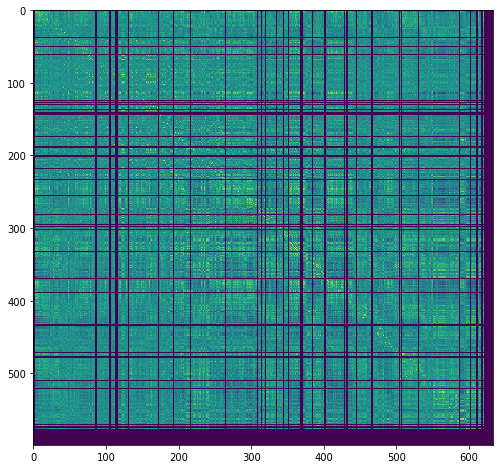

In [95]:

plt.figure(figsize=(10 ,8))
plt.imshow(corr_mat)
plt.show()

In [93]:
# 1 to 1 map by go through
corr_mask = np.ones((list(corr_mat.shape)), dtype = np.bool)
flag=1
inds=np.zeros((1,2),dtype=int)
d=0.6
#while np.max(np.multiply(corr_mat,corr_mask))>t: # flag need to be deleted
for i in range(corr_mask.shape[0]):
    for j in range(corr_mask.shape[1]):

        if corr_mask[i][j] and corr_mat[i][j]>t:
            max_temp=corr_mat[i][j]
            corr_mat[i][j]=-1
            max_next=max(max(corr_mat[i,:]),max(corr_mat[:,j]))
            corr_mat[i][j]=max_temp
            if (1-max_temp)<(1-max_next)*d:
                inds= np.row_stack((inds,np.array(([i,j]))))
                corr_mask[i,:]=False
                corr_mask[:,j]=False
                
inds=(inds.transpose())
inds=np.delete(inds,0,1)        


print('loop end')




loop end


In [88]:
#plt.figure(figsize=(20,30))
corr_mask[:,20]=False
#plt.imshow(corr_mask)
#plt.show()


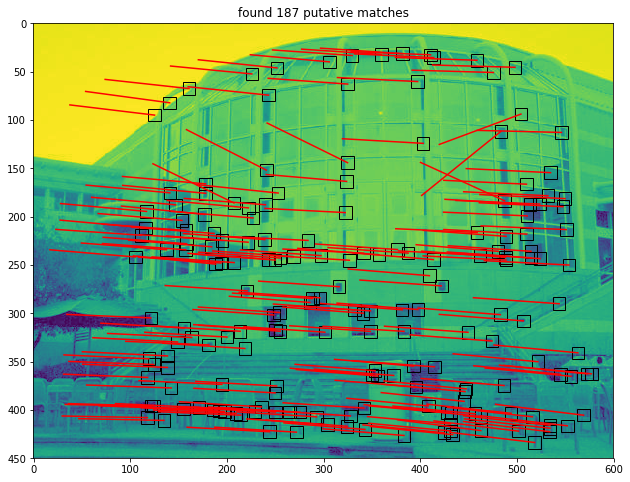

In [94]:
plt.figure(figsize=(14,8))
ax = plt.subplot(1,1,1)
#plt.imshow(np.hstack((I1,I2)))
plt.imshow(I1)
for i in range(inds.shape[1]):
    ii = inds[0,i]
    jj = inds[1,i]
    x1 = pts1_1[0,ii]
    x2 = pts2_1[0,jj]# + I1.shape[1]
    y1 = pts1_1[1,ii]
    y2 = pts2_1[1,jj]
    x1,y1=y1,x1
    x2,y2=y2,x2
    
    plt.plot([x1, x2],[y1, y2],'-r')
    ax.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False))
    #ax.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False))
plt.title('found %d putative matches'%inds.shape[1])
plt.show()

In [ ]:
# parameters to tune
w1 = 13
t1 = 0
d1 = 12
p1 = np.inf
# do the matching
inds, scores = match(I1, I2, pts1_1, pts2_1, w1, t1, d1, p1)
# display the results
plt.figure(figsize=(14,8))
ax = plt.subplot(1,1,1)
#plt.imshow(np.hstack((I1,I2)))
plt.imshow(I1)
for i in range(inds.shape[1]):
    ii = inds[0,i]
    jj = inds[1,i]
    x1 = pts1_1[0,ii]
    x2 = pts2_1[0,jj]# + I1.shape[1]
    y1 = pts1_1[1,ii]
    y2 = pts2_1[1,jj]
    plt.plot([x1, x2],[y1, y2],'-r')
    ax.add_patch(patches.Rectangle((x1-w1/2,y1-w1/2),w1,w1, fill=False))
    #ax.add_patch(patches.Rectangle((x2-w1/2,y2-w1/2),w1,w1, fill=False))
plt.title('found %d putative matches'%inds.shape[1])
plt.show()


In [ ]:
# 1 to 1 map by selecting most value

corr_mask = np.ones((list(corr_mat.shape)), dtype = np.bool)
while flag and np.max(corr_mat)>t: # flag need to be deleted
    

    max_temp=np.max(np.multiply(corr_mat,corr_mask))
    ind_index=0

    pos_max=np.argmax(corr_mat)
    x_max=pos_max//corr_mat.shape[1]
    y_max=pos_max-x_max*corr_mat.shape[1]

    inds=np.zeros((1,2))

    corr_mat[x_max][y_max]=-1
    max_next=max(max(corr_mat[x_max,:]),max(corr_mat[:,y_max]))
    corr_mat[x_max][y_max]=max_temp

    if (1-max_temp)<(1-max_next)*d:

        inds[0,ind_index]=x_max
        inds[1,ind_index]=y_max
        inds= np.row_stack(inds,np.array(([x_max,y_max])))
        corr_mask[x_max,:]=False
        corr_mask[:,y_max]=False

        flag=0  ## need to be deleted, just for test

    else:
    
    
    
    
    
    


















print('set done')


In [ ]:
#arr = np.ones((3,2), dtype = np.bool)
a=np.array(([3,2,4],[5,3,2],[4,5,6]))
for i in a:
    print(i)

In [ ]:
pts1_1.shape

In [ ]:
I=I1
m,n = I.shape[:2]

J0 = np.zeros((m,n))
J1 = np.zeros((m,n))
J2 = np.zeros((m,n))

w=15
w_2=(w-1)//2

w_num=7
w_num_2=(w_num-1)//2

thres=0
kx=np.array([-1,8,0,-8,1])/12

Ix0 = np.zeros((m,n))
Iy0 = np.zeros((n,m))

for i in range(len(I)):
    Ix0[i]=np.convolve(kx,I[i],'same')

for i in range(len(I.transpose())):
    Iy0[i]=np.convolve(kx,I.transpose()[i],'same')
Iy0=Iy0.transpose()


IxIx=np.multiply(Ix0,Ix0)
IxIy=np.multiply(Ix0,Iy0)
IyIx=np.multiply(Iy0,Ix0)
IyIy=np.multiply(Iy0,Iy0)
N=np.zeros((2,2))

pts0 = np.array([0,0])
pts1 = np.array([0,0])
N2=np.zeros((2,1))

for i in range(w_2,m-w_2):
    for j in range(w_2,n-w_2):
        N[0][0]=np.sum(IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
        N[0][1]=np.sum(IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
        N[1][0]=np.sum(IyIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
        N[1][1]=np.sum(IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
        
        #sq_temp=np.trace(N)**2-4*np.linalg.det(N)
        
        lbd_l=(np.trace(N)-abs(np.trace(N)**2-4*np.linalg.det(N))**0.5)/2
        #lbd_l=(np.trace(N)-((sq_temp>0)*sq_temp)**0.5)/2
        
        J0[i][j]=lbd_l
        
J1=np.multiply(J0>thres,J0)    

for i in range(w_num_2,m-w_num_2):
    for j in range(w_num_2,n-w_num_2):
        J2[i][j]=(J1[i][j] == np.max(J1[i-w_num_2:i+w_num_2+1,j-w_num_2:j+w_num_2+1]))*J1[i][j]

for i in range(m):
    for j in range(n):
        if J2[i][j]>0:
            pts0=np.row_stack((pts0, np.array([i,j])))

pts0=np.delete(pts0,0,0)

for [i,j] in pts0:
    
    x_temp=np.dot(np.ones((w,1)),np.array([range(i-w_2,i+w_2+1)]))
    y_temp=np.dot(np.ones((w,1)),np.array([range(j-w_2,j+w_2+1)]))
    y_temp=y_temp.transpose()
    
    N[0][0]=np.sum(IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
    N[0][1]=np.sum(IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
    N[1][0]=np.sum(IyIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
    N[1][1]=np.sum(IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])/(w*w)
    
    N2[0]=np.sum(np.multiply(x_temp,IxIx[i-w_2:i+w_2+1,j-w_2:j+w_2+1])+\
                 np.multiply(y_temp,IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1]))/(w*w)

    N2[1]=np.sum(np.multiply(x_temp,IxIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1])+\
                 np.multiply(y_temp,IyIy[i-w_2:i+w_2+1,j-w_2:j+w_2+1]))/(w*w)

    pts1=np.row_stack((pts1, np.linalg.solve(N,N2).transpose()))
    
pts1=np.delete(pts1,0,0)




In [ ]:
#I1, I2, pts1, pts2, w, t, d, p
# correlation coefficient calculation with window adjusted
pts1=pts1_1.transpose()
pts2=pts2_1.transpose()
w=11
t=0
d=12
p=np.inf

w_2=(w-1)//2
m_corr,n_corr = 0,0
corr_mat = np.zeros((pts1.shape[0],pts2.shape[0]))

for [i1,j1] in pts1:
    for [i2,j2] in pts2:
        
        i1=int(round(i1))
        j1=int(round(j1))
        i2=int(round(i2))
        j2=int(round(j2))
        
        up_1=j1-max(j1-w_2,0)
        dwn1=min(j1+w_2+1,I1.shape[1])-j1
        lft1=i1-max(i1-w_2,0)
        rht1=min(i1+w_2+1,I1.shape[0])-i1
        
        up_2=j2-max(j2-w_2,0)
        dwn2=min(j2+w_2+1,I2.shape[1])-j2
        lft2=i2-max(i2-w_2,0)
        rht2=min(i2+w_2+1,I2.shape[0])-i2
        
        up_min = min(up_1 , up_2)
        dwnmin = min(dwn1 , dwn2)
        lftmin = min(lft1 , lft2)
        rhtmin = min(rht1 , rht2)
               
        win_temp=I1[i1-lftmin:i1+rhtmin,j1-up_min:j1+dwnmin]
        win_mean1= win_temp - np.mean(win_temp)
        win_sigma1=(np.sum(win_mean1**2))**0.5
        
        #corr_coef calcuate
        
        win_temp=I2[i2-lftmin:i2+rhtmin,j2-up_min:j2+dwnmin]
        
        win_mean2= win_temp - np.mean(win_temp)
        win_sigma2=(np.sum(win_mean2**2))**0.5
        corr_mat[m_corr][n_corr]=np.sum(np.multiply(win_mean1,win_mean2))/\
        (win_sigma1*win_sigma2)
        
        
        
        n_corr=n_corr+1
    m_corr=m_corr+1
    n_corr=0
        
#while np.max(corr_mat)>t:
   # max_temp=np.max(corr_mat)
    
print('done_co_eff')











